Imports

In [17]:
import os
import json
import torch
import pandas as pd
from datasets import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Configuration

In [ ]:
BASE_PATH = "../Data/"
REVIEWS_FILE = "yelp_academic_reviews4students.jsonl"
MODEL_NAME = "google-bert/bert-base-uncased" # Modele bert 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation du périphérique : {device}")

Utilisation du périphérique : cuda


Préparation des données

In [19]:
data = [] # Liste pour stocker JSON
with open(REVIEWS_FILE, 'r', encoding='utf-8') as f:
    for line in f:
        data.append(json.loads(line))

df_all = pd.DataFrame(data)

# Mapping 1-5 étoiles vers labels 0-4
df_all['label'] = df_all['stars'].apply(lambda x: int(x - 1))

# DEFINITION DE LA LIMITE : 20 000 au total (4 000 par classe)
N_TOTAL = 20000
N_PER_CLASS = N_TOTAL // 5

# Équilibrage et échantillonnage limité
dfs = [df_all[df_all['label'] == i].sample(N_PER_CLASS, random_state=42) for i in range(5)]
df_balanced = pd.concat(dfs).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Jeu de données limité à {len(df_balanced)} lignes ({N_PER_CLASS} par classe).")

# Conversion format Hugging Face Dataset
dataset = Dataset.from_pandas(df_balanced[['text', 'label']])
dataset = dataset.train_test_split(test_size=0.1)

Jeu de données limité à 20000 lignes (4000 par classe).


Tokenisation

In [20]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

def tokenize_fn(examples):
    # Troncature à 128 et padding fixe pour le GPU
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

print("Tokenization des avis (5 classes)...")
tokenized_datasets = dataset.map(tokenize_fn, batched=True)

Tokenization des avis (5 classes)...


Map: 100%|██████████| 2000/2000 [00:00<00:00, 8492.57 examples/s]


Initiation du modéle 

In [21]:
# Initialisation avec num_labels=5 pour la classification multi-classe
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=5)
model.to(device)

Loading weights: 100%|██████████| 199/199 [00:00<00:00, 772.81it/s, Materializing param=bert.pooler.dense.weight]                               
BertForSequenceClassification LOAD REPORT from: google-bert/bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSI

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

Fonction de Calcul des Métriques

In [22]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1) # Sélection de la classe dominante
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

Configuration de l'Entraînement

In [23]:
training_args = TrainingArguments(
    output_dir="./results_bert_5classes",
    num_train_epochs=3,                 # 2 époques suffisent pour le fine-tuning 5 classes
    per_device_train_batch_size=16, 
    gradient_accumulation_steps=2,      # Simule un batch de 32
    fp16=True,                          # Accélération GPU
    logging_steps=100,
    eval_strategy="no",                 # Désactivé pour accélérer le processus
    save_strategy="no",
    report_to="none"
)

Le Trainer et le Lancement

In [24]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    compute_metrics=compute_metrics
)

if training_args.device.type == 'cuda':
    print(f"Entraînement lancé sur : {torch.cuda.get_device_name(0)}")

trainer.train()

Entraînement lancé sur : NVIDIA GeForce RTX 2070 SUPER


Step,Training Loss
100,2.421221
200,1.998600
300,1.938762
400,1.830946
500,1.828997
600,1.740907
700,1.477465
800,1.438312
900,1.416607
1000,1.396511


TrainOutput(global_step=1689, training_loss=1.450734180836652, metrics={'train_runtime': 2669.645, 'train_samples_per_second': 20.227, 'train_steps_per_second': 0.633, 'total_flos': 3552094923264000.0, 'train_loss': 1.450734180836652, 'epoch': 3.0})

Evaluation


--- Rapport de classification BERT (5 classes) ---
              precision    recall  f1-score   support

    1 étoile       0.78      0.70      0.74       402
   2 étoiles       0.53      0.62      0.57       392
   3 étoiles       0.53      0.49      0.51       397
   4 étoiles       0.58      0.59      0.58       406
   5 étoiles       0.76      0.76      0.76       403

    accuracy                           0.63      2000
   macro avg       0.64      0.63      0.63      2000
weighted avg       0.64      0.63      0.63      2000



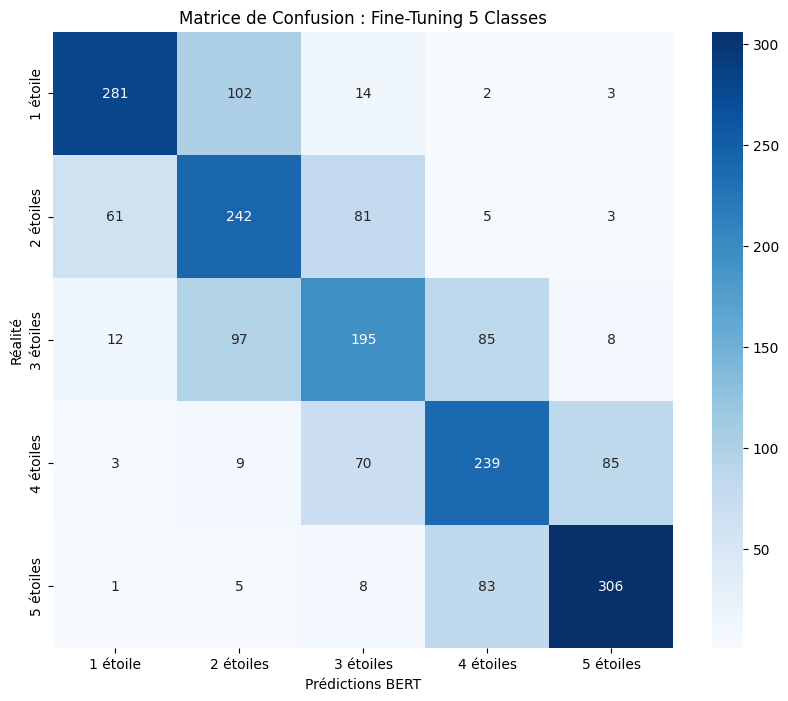

In [25]:
# Inférence sur le set de test
predictions = trainer.predict(tokenized_datasets["test"])
y_pred = predictions.predictions.argmax(-1)
y_true = predictions.label_ids

target_names = ['1 étoile', '2 étoiles', '3 étoiles', '4 étoiles', '5 étoiles']
print("\n--- Rapport de classification BERT (5 classes) ---")
print(classification_report(y_true, y_pred, target_names=target_names))

# Visualisation des erreurs via Matrice de Confusion
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, 
            yticklabels=target_names)
plt.xlabel('Prédictions BERT')
plt.ylabel('Réalité')
plt.title('Matrice de Confusion : Fine-Tuning 5 Classes')
plt.show()

Sauvegarde du modèle 

In [26]:
model.save_pretrained("./final_bert_yelp_5classes")
tokenizer.save_pretrained("./final_bert_yelp_5classes")
print("Modèle 5 classes sauvegardé avec succès.")

Writing model shards: 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


Modèle 5 classes sauvegardé avec succès.
